# Overview of Electricity Generation in the USA based on EIA data

The following is an exercise in using data from the Electricity Information Agency (EIA),
to familiarize myself with both the broad state of the US electrical grid, as well as some exploratory data analysis.
This is based on the bulk ELEC dataset, which contains monthly temporal resolution, and has plant level
and state level summaries.  The dataset includes generation by source, fuel quality, number of customers, cost of electricity and sales.
While the EIA offers an API for current access, but as someone new to this dataset it was simpler to start exploring from the bulk data set, which is only around 1GB. 

## Motivation

Why study the electrical grid? 
First, the electrical grid is a complex system of hundreds of utilities, each of which requires good forecasting
in order to ensure smooth operation.
Second, renewable energy sources like solar and wind are taking up larger parts of the energy generation mix.
Both of these have stochastic components.
In order to curtail CO2 emissions, both of these are likely to become much larger parts of the energy mix,
and thus good forecasts will be required for both generation as well as demand.
I found this [(MIT Study)](http://web.mit.edu/mitei/research/studies/the-electric-grid-2011.shtml) helpful for discussing the state of the grid and the challenges to including these variable energy sources.

## Data Sources

Fortunately, the EIA provides public [data](https://www.eia.gov/opendata/) on the grid and energy use in general.
The EIA allows data access to seeing bulk characteristics of this system over the 15 years,
as well as higher resolution hourly data on the state of the grid access since 2015.
(Earlier datasets had 15-minute resolution, but that has been reduced to hourly resolution).

For weather data we can use NOAA's Automated Surface Observing System [(ASOS)](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/automated-surface-observing-system-asos).
to gather high resolution weather data from airports around the country. 

## Notebook Overview

This notebook uses the bulk electricity data set from [here](https://www.eia.gov/opendata/bulkfiles.php)
for some exploratory analysis.
The dataset proper is in JSON format with around 500k series,
and totals about 1GB.
The analysis was primarily done in Python and SQL.
I used a PostGRESQL database to store the data, Psycopg2 to interact with the database, and Pandas for the data analysis. 
My goal is to explore the overall state of generation, get a sense of which states are the largest generators,
and how the energy mix varies, how rene





In [119]:
#Load libraries
import pandas as pd
import numpy as np
import sqlalchemy
import psycopg2
import datetime 
import matplotlib.pyplot as plt
from psycopg2 import sql
from mpl_toolkits.basemap import Basemap  #mapping utility
import pickle   #Useful for caching maps

#Load in my subroutines for using psycopg2, converting data and ploting
from util.sql_lib import safe_sql_query, get_column_query, get_dataframe
from util.ELEC_lib import convert_data, plot_data_frame, plot_generation_by_state, plot_retail_price, plot_customers
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The data is provided as JSON format, with lots of metadata, and connections between series.  The data was split into chunks, and loaded into SQL as text (The time series proper are stored as a single list for each entry.)

The loading process is done in "json\_to\_sql.py" script,
after the bulk file had been split.

In order to query the data we need to create a psycopg2 connection, which can interact with the database,
and is used by other subroutines to pull data into pandas dataframes.

In [3]:
#Set up connections to SQL database, which was generated from the bulk JSON file.
database_name='US_ELEC'
fname='ELEC'
table_name=fname
engine=sqlalchemy.create_engine("postgresql+psycopg2://localhost/"+database_name)

#make connection to database (which is needed by Pandas), 
# and the cursor which actually executes SQL commands.
conn=psycopg2.connect(dbname=database_name,host='localhost')
conn.set_session(autocommit=True)
cur = conn.cursor()

As a quick check, let's query the number of series within the "ELEC" table.

In [4]:
#count the number of series
q=sql.SQL('SELECT count(*) FROM "ELEC"')
cur.execute(q)
cur.fetchall()

[(562601,)]

The following defines some useful functions for grabbing SQL queries, and loading the desired columns into a Pandas DataFrame.
Most of this is just converting python variables to SQL variables, for simple SQL queries of the form
"SELECT {columns} FROM table WHERE name like '{pattern}' and freq LIKE {freq}".

Here the pattern will include things like the type of series, e.g. Net Generation,
the location, e.g. Oregon or the U.S., and any further distinguishing features, like the type of generation.

## United States Seasonal Variation

Let's now look at national level data for the United States as a whole.
We'll pull in all data for the US as a whole with monthly time resolution.

In [10]:
#grab the data from SQL.  Also converts each data string into a series (associated with each name/id)
out_col=('name','data','start','end','f')
match_names=[': United States :'];    
df_usa=get_dataframe(cur,'ELEC',out_col,match_names,freq='M');
data0=convert_data(df_usa)
df_usa['data2']=data0

Nrows 915


First, lets look at the types of series available on a national level.  We'll find the type of series by splitting up the names, and counting the numbers of each type of series.

The structure of the names is something like
"{Series Type} : {Location} : {Further sub-type}"


In [11]:
#split all series names at ':', and grab first entry of resulting list to get the highest level type of series.
name_split=df_usa['name'].str.split(':')
name0=name_split.apply(lambda x: x[0])
name_df=pd.DataFrame(name0,columns=['name'])
unique_names=name0.unique()

In [50]:
#count up number of each type of series.
counts=np.zeros(len(unique_names))
i=0
for name in unique_names:
    #avoid using regex to allow parentheses
    counts[i]=np.sum(name0.str.contains(name,regex=False))
    i+=1

name_df=pd.DataFrame(data={'name':unique_names,'count':counts})
print(name_df)

    count                                                                name
0     6.0                                        Retail sales of electricity 
1   150.0                     Receipts of fossil fuels by electricity plants 
2   115.0                  Quality of fossil fuels in electricity generation 
3    18.0                      Fossil-fuel stocks for electricity generation 
4     6.0                           Revenue from retail sales of electricity 
5    75.0               Receipts of fossil fuels by electricity plants (Btu) 
6     6.0                                Average retail price of electricity 
7   196.0                                                     Net generation 
8    94.0                                                  Total consumption 
9     5.0                                        Number of customer accounts 
10  150.0            Average cost of fossil fuels for electricity generation 
11   37.0                        Consumption for useful thermal 

The bewildering number of series is due to the number of types of fuel, and differing types of fuels associated with each type of generation, as well as variation by sector and size of generator.  

In [13]:
#Find unique types of generation by further splitting
msk=df_usa['name'].str.contains('Net generation')
df_usa[msk]['name'].str.split(':').apply(lambda x:x[1]).unique()

array([' wind ', ' coal ', ' natural gas ', ' other biomass ', ' all utility-scale solar ', ' nuclear ', ' other ', ' conventional hydroelectric ',
       ' wood and wood-derived fuels ', ' other gases ', ' hydro-electric pumped storage ', ' petroleum liquids ', ' utility-scale photovoltaic ',
       ' utility-scale thermal ', ' all solar ', ' all fuels ', ' petroleum coke ', ' distributed photovoltaic ', ' geothermal ',
       ' other renewables (total) '], dtype=object)

Lets now plot the main generators on the national level.  

In [9]:
#Plot out each of the rows of a dataframe, with the label given by the name of the row.

In [48]:
#select out series across all sectors for each type of generation
msk1=df_usa['name'].str.contains('Net generation')
msk2=df_usa['name'].str.contains('all sectors')
df_gen=df_usa[msk1&msk2]
#now sort plotting order by which has largest values.
#find the maximum generation for each type of generation in 2016.
Ngen=len(df_gen.index)
df_gen_max=pd.Series(np.zeros(Ngen),index=df_gen.index)
for ind,row in enumerate(df_gen['data2']):
     df_gen_max.iloc[ind]=row.loc['2016'].max()
plt_ind=df_gen_max.sort_values(ascending=False).index
#extract out source part of labels via regex, select first match, and convert to array
gen_labels=df_usa.iloc[plt_ind]['name'].str.extractall('Net generation : ([\s\w\(\)-]+):')[0].values

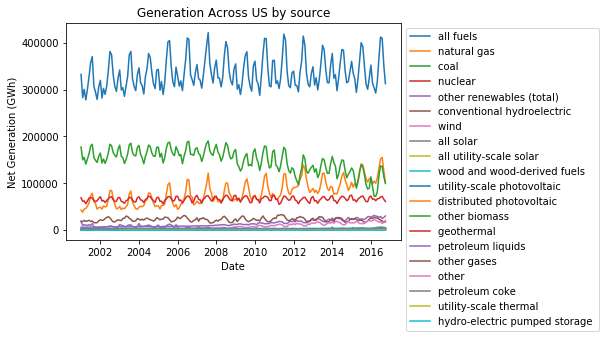

In [133]:
plot_data_frame(df_usa.iloc[plt_ind],xlabel='Date',
ylabel='Net Generation (GWh)',title='Generation Across US by source',
labels=gen_labels)

Evidently coal, natural gas and nuclear power provide the vast majority of the US's electrical supply.
While coal use is declining, that decline is matched by an increase in the use of natural gas. 
Nuclear power is fairly stable, reflecting that there are few new nuclear plants being built.

Of the renewables, wind and hydroelectric are the dominant providers.
Hydroelectric is the largest renewable, but is largely static, reflecting the fact that most available hydro sources have already been exploited.
Solar capacity has shown exponential growth, the supply of wind-based electricity generation has been growing over the last decade. 

Note that these are all monthly totals.  These do not capture the short scale fluctuations that can occur on the minute to hour timescale which can impact the usefulness of renewables, and are the primary difficulty in incorporating them into the grid.

Let's look at another plot focusing on the smaller renewable sources, on both log/linear scales.

In [18]:
df_gen_sub=df_usa.iloc[plt_ind]

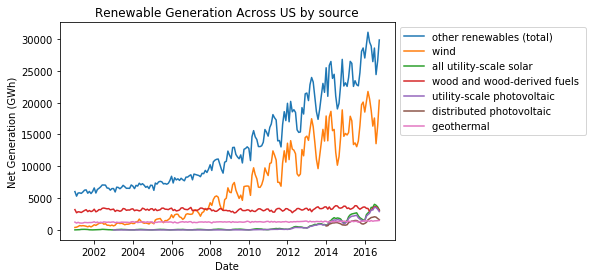

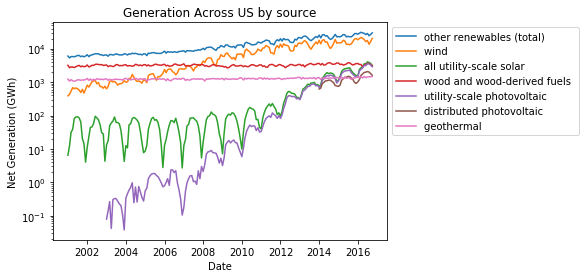

In [132]:
sub_ind=[4,6,8,9,10,11,13]
plt.figure()
plot_data_frame(df_usa.iloc[plt_ind[sub_ind]],
xlabel='Date',
ylabel='Net Generation (GWh)',title='Renewable Generation Across US by source',
labels=gen_labels[sub_ind],logy=False)
plt.figure()
plot_data_frame(df_usa.iloc[plt_ind[sub_ind]],
xlabel='Date',
ylabel='Net Generation (GWh)',title='Generation Across US by source',
labels=gen_labels[sub_ind],logy=True)

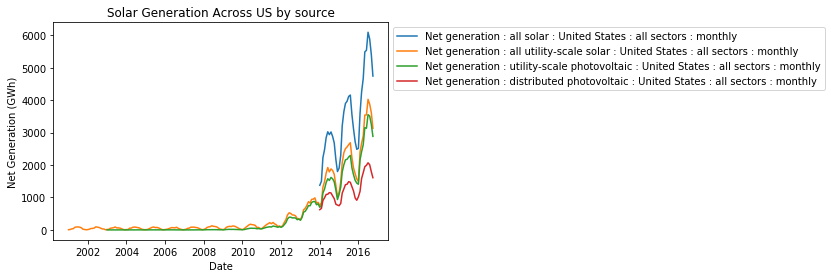

In [173]:
d0=df_gen[df_gen['name'].str.contains('solar|photo')]
plot_data_frame(d0,
xlabel='Date',
ylabel='Net Generation (GWh)',title='Solar Generation Across US by source')

#plt.plot(d0['data2'])

The last decade has seen wind and solar capacity growing exponentially, with wind having a large overall contribution, while utility scale solar is growing fastest of all. Otherwise there's multiple other small sources, which have been roughly constant over the period. Petroleum liquids show a similar dropoff to coal usage.

Pumped storage is an anomaly: it's negative, and relatively constant.
This reflects the practice of pumping water uphill as stored energy when demand is low, or energy is cheap. The grid will need a whole lot of energy storage to offset the variability of sources like photovoltaics and wind.

So the overall picture is that coal use was decreasing, mostly offset by natural gas, presumably related to cheap gas available from fracking.
Of the zero-carbon sources, nuclear energy and hydro are fairly stable, while wind and solar use are growing exponentially.

## State-by-state Generation

Let's look at the main contributors for Oregon's electricity generation.

Nrows 16


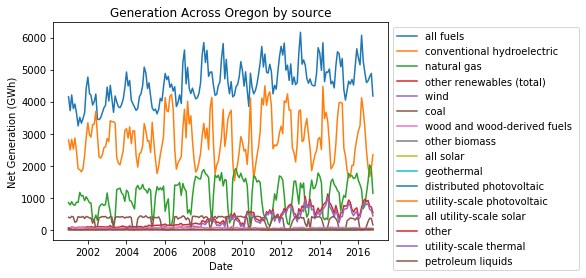

In [131]:
plot_generation_by_state(cur,'Oregon')

Oregon has bountiful rivers, particularly the Columbia which
forms the border with Washington.
The Columbia provides the majority of Oregon's electricity via
conventional hydroelectric generation.  Otherwise
natural gas, wind and coal provide the remainder.  Of these
wind is growing the fastest, presumably driven by wind-farms along the
Columbia Gorge and in Eastern Oregon.

In comparison, let's look at some other large states like Texas and California.

Nrows 18


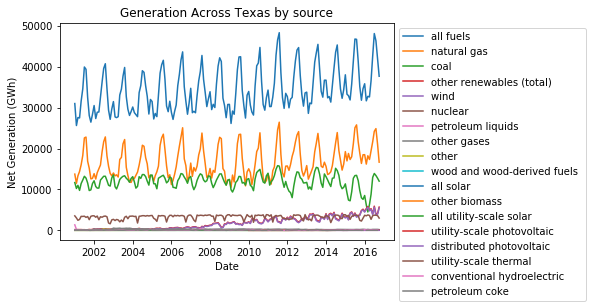

In [130]:
plot_generation_by_state(cur,'Texas')

Texas is a much bigger economy than Oregon, and also has its own separate electrical grid.  Note that it's 10x larger than Oregon was.  Here the energy mix is similar to the US as a whole: mostly natural gas, declining coal, a small amount of nuclear, and growing wind.  

Nrows 17


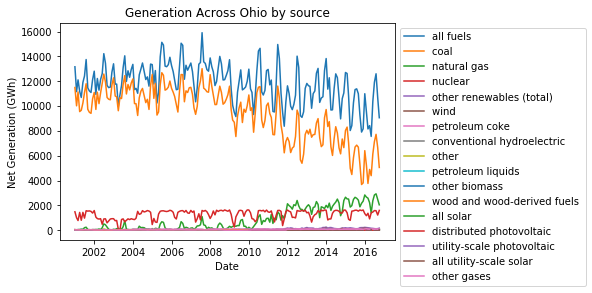

In [129]:
plot_generation_by_state(cur,'Ohio')

Different again is Ohio, which is dominated by coal.  Here again coal use is decreasing (down by nearly 40%), and natural gas is increasing.
However it seems that Ohio imports more of it's energy as energy use overall has decreased.

## Cost of Electricity

The other side of this is looking at the markets: customers, sales and costs of electricity.  Generation might occur in one place, but be sold to another state.  Let's start with retail price.  

Nrows 6


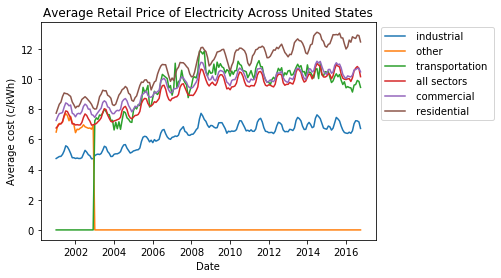

In [128]:
plot_retail_price(cur,'United States')

Nrows 6


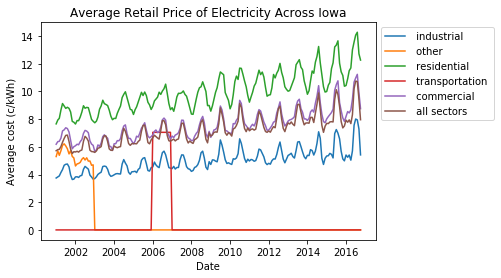

In [127]:
plot_retail_price(cur,'Iowa')

So prices have seen slow growth.  Once again, there is a clear seasonal pattern.  Residential customers pay the most, relative to commerical and industrial customers.  (perhaps reflects lack of certainty about demands/greater fluctuations/weaker negotiating power compared with industrial purposes.)  Looking at some state level estimates shows a large variation in seasonalilty and increases (e.g. Oregon, Washington show a slow increase, but Texas saw prices decrease since 2008.

# Customer Accounts

Let's grab the number of customer accounts (residential, commercial, industrial) for each state.
The national plots show a slow growth, so we'l plot that and the totals. We can use the number of residential accounts as a proxy for population.

Most of these are fairly smooth, although some states like California
and Washington show an anomalous amount of noise.

Nrows 5


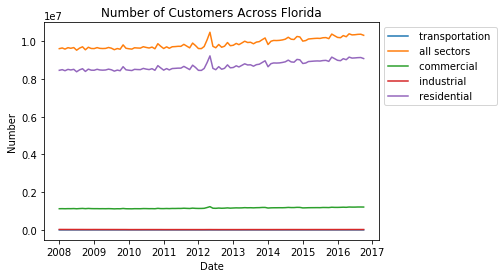

In [126]:
plot_customers(cur,'Florida')

## Geographic variability in 2016

Time to break out some Matplotlib.baseplot goodness for plots of the US.
(This is also directly relevant to the data available from the EIA, since the US is broken into 5 major power regions,
which then interact by buying and selling electricity from one another.)
Using annual data, which states use the most electricity of each type?

Questions:
-Largest growth in solar/wind since 2001. 
-which state used most electricity in 2016/2017.
-which state generated most electricity


In [96]:
from plot_usage import create_instance, plot_us_data, make_pop_data
from util.ELEC_lib import get_state_data

In [106]:
yr='2014'
df_tot=get_state_data(cur,yr)

Automatic pdb calling has been turned ON


Loaded Basemap from file


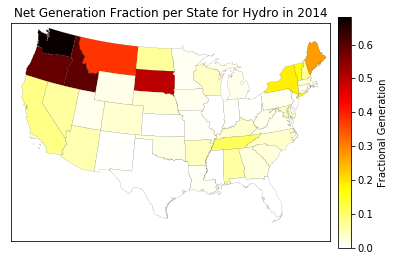

In [125]:
%pdb on 
fig, ax = plt.subplots()
m,m_=create_instance()
plot_us_data(fig,ax,m,m_,data=(df_tot['HYC']/df_tot['ALL']).astype(float),
label_text=r'Fractional Generation',title_text='Net Generation Fraction per State for Hydro in '+yr)

Loaded Basemap from file


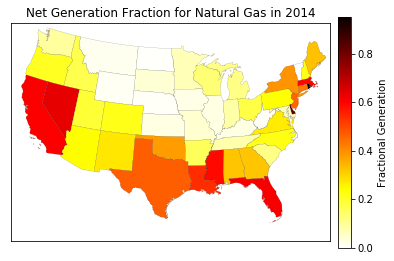

In [124]:
fig, ax = plt.subplots()
m,m_=create_instance()
plot_us_data(fig,ax,m,m_,data=(df_tot['NG']/df_tot['ALL']).astype(float),
label_text=r'Fractional Generation',title_text='Net Generation Fraction for Natural Gas in '+yr)

Loaded Basemap from file


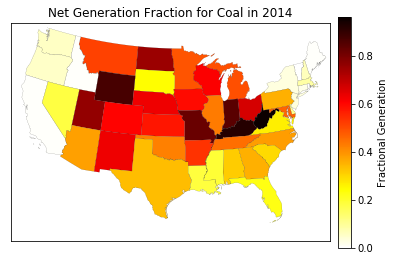

In [123]:
fig, ax = plt.subplots()
m,m_=create_instance()
plot_us_data(fig,ax,m,m_,data=(df_tot['COW']/df_tot['ALL']).astype(float),
label_text=r'Fractional Generation',title_text='Net Generation Fraction for Coal in '+yr)

Loaded Basemap from file


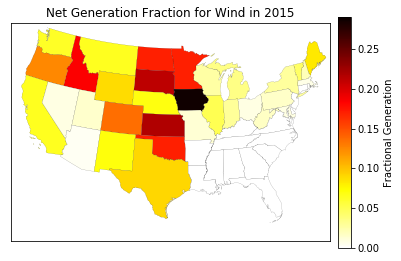

In [122]:
fig, ax = plt.subplots()
m,m_=create_instance()
plot_us_data(fig,ax,m,m_,data=(df_tot['WND']/df_tot['ALL']).astype(float),
label_text=r'Fractional Generation',title_text='Net Generation Fraction for Wind in 2015')

Loaded Basemap from file


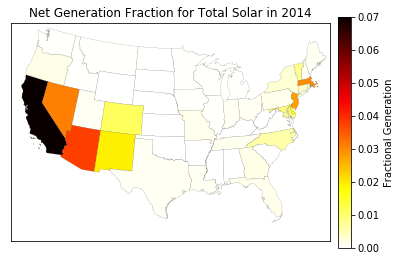

In [121]:
fig, ax = plt.subplots()
m,m_=create_instance()
plot_us_data(fig,ax,m,m_,data=(df_tot['TSN']/df_tot['ALL']).astype(float),
label_text=r'Fractional Generation',title_text='Net Generation Fraction for Total Solar in '+yr)

Some striking patterns here.  These plots are looking at fraction of the total generated.  There seem to be some pretty clear political/incentive effects here.  For example in solar: the north east is a poor place for solar, yet a larger fraction is generated there, over places like Texas or Utah.  (So there's an obvious political dimension to this).

Wind shows less of a crazy divide.  Natural Gas is conspicuous in its absence across the central US - I think there it competes with existing coal plants.  Looking at the trend over time, it looks like Natural Gas has supplanted Coal generation - yet another political angle in terms of new plants.

Hydro is heavily dependent on the available resource - the Columbia gorge is super obvious in OR/WA generation.  This isn't showing Canada's huge hydro generation, which is a major exporter of electricity to the US.  

## Near Real-time data.

Now to load in some of the actual operating data (which is in a different table in the same database).
Ok, that is not really working, since I screwed up loading the data into the database.


In [7]:
database_name='US_ELEC'
fname='EBA'
table_name=fname
engine2=sqlalchemy.create_engine("postgresql+psycopg2://localhost/"+database_name)
#make connection to database (which is needed by Pandas), 
# and the cursor which actually executes SQL commands.
conn2=psycopg2.connect(dbname=database_name,host='localhost')
conn2.set_session(autocommit=True)
cur2 = conn2.cursor()

In [35]:
def fetch_eba_series(cur2,region,series_type):
    """fetch_eba_series(cur2,region,series_type)
    Call PostgreSQL server to pull up the series relating to
    a given region and type of series.
    
    cur2: psycopg2 cursor object on relevant table
    region: name of the region/ISO we want the series for
    series_type: the type of data series for a given ISO
    """
    print('Getting '+region+':'+series_type);
    df=get_dataframe(cur2,'EBA',out_col,[region,series_type],freq='H');
    data0=convert_data(df)
    df['data2']=data0
    return df

#Read in some representative data.
out_col=('name','data','start','end','f')
df_eba_tot=pd.DataFrame()

region_list=["Northwest (region)",'Southwest (region)','Southeast (region)',\
            'Midwest (region)','Central (region)','California (region)',\
            'Texas','Tennessee','Florida (region)','Carolinas (region)','New York','New England'];
series_type=['Net generation','Demand','demand forecast','retail'];
for region in region_list:
#     for gen_type in series_list:
    series_type='Demand'
    df = fetch_eba_series(cur2,region,series_type)
    print(df['name'])
    df_eba_tot=df_eba_tot.append(df)


Getting Northwest (region):Demand
1
Converting # 0
0    Demand for Northwest (region), Hourly
Name: name, dtype: object
Getting Southwest (region):Demand
1
Converting # 0
0    Demand for Southwest (region), Hourly
Name: name, dtype: object
Getting Southeast (region):Demand
1
Converting # 0
0    Demand for Southeast (region), Hourly
Name: name, dtype: object
Getting Midwest (region):Demand
1
Converting # 0
0    Demand for Midwest (region), Hourly
Name: name, dtype: object
Getting Central (region):Demand
1
Converting # 0
0    Demand for Central (region), Hourly
Name: name, dtype: object
Getting California (region):Demand
1
Converting # 0
0    Demand for California (region), Hourly
Name: name, dtype: object
Getting Texas:Demand
1
Converting # 0
0    Demand for Electric Reliability Council of Texas, Inc. (ERCO), Hourly
Name: name, dtype: object
Getting Tennessee:Demand
1
Converting # 0
0    Demand for Tennessee Valley Authority (TVA), Hourly
Name: name, dtype: object
Getting Florida (regio

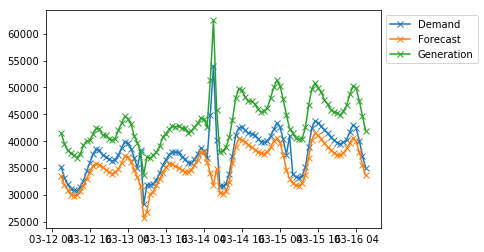

In [33]:
#check for weird points.  This plot is fore the region of maximum discrepency between the forecast and actual demand.
t0=np.argmax(abs(d2-d1))
delta=pd.Timedelta(2,'D');
t1 = t0-delta;
t2= t0+delta;
trange=pd.DatetimeIndex(start=t1,end=t2,freq='H')
plt.plot(trange,d1[trange],'-x',label='Demand')
plt.plot(trange,d2[trange],'-x',label='Forecast')
plt.plot(trange,d0[trange],'-x',label='Generation')
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()


In [ ]:
So that wasn't an error, but a real spike in demand.  Obviously the generation made up the difference.

I would like to review the sources of electricity to get a sense of seasonal variations (in terms of availability and use).
For example, I'd expect solar generation to be largest in summer, lowest in winter.  
I would assume this varies geographically.  I'll assume the seasonality can be averaged over by using the annual data. 

Residential Use will be largest in winter, barring the occasional fluctuation in summer.  

The purpose of this survey is to identify the scale of renewables in the market.  
How large a share do renewables (solar, hydro, wind) take up?  How does this vary regionally?  Over time? 
Who are the primary users of electricity?  
I'll assume the base load is provided by coal, gas and nuclear plants.  

This is meant to be a brief background piece for that.  Since we are forecasting a time series,
I aim to use TensorFlow with some form of neural network (perhaps recurrent) to try forecasting.
Ideally, I would cross-reference the electricity data sets against the published weather forecasts for a given day.  
The model should be able to predict demand given the location, time of year, and weather forecast.  (This is probably the 
simplest thing available)

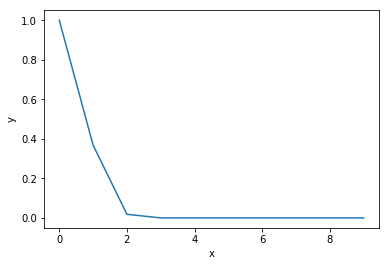

In [120]:
x=np.arange(10)
y= np.exp(-x*x);
fig=plt.plot(x,y)
_=plt.xlabel('x')
_=plt.ylabel('y')